# Inerpretation-Net

## Specification of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', 
    },
    'data': {
        'number_of_variables': 2, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'use_distribution_list': True,
        'random_parameters_distribution': True,
        'max_distributions_per_class': 1, # None; 0; int >= 1  
        'exclude_linearly_seperable': True,
        'data_generation_filtering': False,
        'fixed_class_probability': False,
        'balanced_data': True,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'dt_type_train': 'vanilla', 
        'maximum_depth_train': 3, 
        'decision_sparsity_train': 1, 
        
        'function_generation_type': 'distribution',
        'distrib_by_feature': True,
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'], 
        'distribution_list_eval': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],
        
        'objective': 'classification', 
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', 
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', 
        
        'data_noise': 0, #None or float
        
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'restore_best_weights': True,
        'patience_lambda': 50,
        
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', 
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [1792, 512, 512],
        
        'dropout': [0, 0, 0.5],

        'hidden_activation': 'sigmoid',

        'optimizer': 'adam', 
        
        'learning_rate': 0.001,
        
        'separate_weight_bias': False,
        
        'convolution_layers': None,
        'lstm_layers': None,        
        'additional_hidden': False,
        
        'loss': 'binary_crossentropy', 
        'metrics': ['binary_accuracy'], 
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50000, #Float for fraction, Int for number 0
        'evaluate_distribution': True,
        'force_evaluate_real_world': False,
        
        'function_representation_type': 5, #
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, 
        'function_value_loss': True, 
                      
        'data_reshape_version': None, 
        
        'resampling_strategy': None,
        'resampling_threshold': 0.2,
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', 
        'nas_trials': 60,
        'nas_optimizer': 'greedy' 
    },    
    
    'evaluation': {           
        'number_of_random_evaluations_per_distribution': 10,
        'random_evaluation_dataset_size_per_distribution': 10_000, 
        'optimize_sampling': True,
            
        'random_evaluation_dataset_size': 500, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 50,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}

### Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import xgboost as xgb



In [4]:
tf.__version__

'2.8.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type >= 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type >= 3 and dt_type == 'SDT'
  else None
                                                            )


if distrib_by_feature:
    config['evaluation']['random_evaluation_dataset_distribution'] = config['data']['distribution_list_eval']
    config['data']['distribution_list'] = [config['data']['distribution_list']]
    config['data']['distribution_list_eval'] = [config['data']['distribution_list_eval']]
  
    

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)  

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var2_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1792-512-512_drop0-0-0.5e500b256_adam_funcRep5_reshapeNone
lNetSize5000_numLNets10000_var2_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
#%load_ext autoreload
#%autoreload 2

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['data']['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    
    
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'
    
    if True:
        path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_X_data, 'rb') as f:
            X_data_list = pickle.load(f)

        path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_y_data, 'rb') as f:
            y_data_list = pickle.load(f)        
            
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    #if no_noise == False:
    #    network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    #    distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              X_test_network[1].values,
                                              y_test_network[1].values,
                                              config) for X_test_network, y_test_network, network_parameters_row, distribution_parameters_row in zip(X_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     y_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     network_parameters.values[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     distribution_parameters.values[:config['i_net']['interpretation_dataset_size']]))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
        lambda_net_dataset_valid = lambda_net_dataset_eval
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:   11.7s
[Parallel(n_jobs=50)]: Done 217 tasks      | elapsed:   12.2s
[Parallel(n_jobs=50)]: Done 932 tasks      | elapsed:   13.1s
[Parallel(n_jobs=50)]: Done 2000 tasks      | elapsed:   13.9s
[Parallel(n_jobs=50)]: Done 3408 tasks      | elapsed:   14.8s
[Parallel(n_jobs=50)]: Done 5072 tasks      | elapsed:   15.9s
[Parallel(n_jobs=50)]: Done 6992 tasks      | elapsed:   17.1s
[Parallel(n_jobs=50)]: Done 9168 tasks      | elapsed:   18.5s
[Parallel(n_jobs=50)]: Done 10000 out of 10000 | elapsed:   18.9s finished


### Data Inspection

In [13]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0 and not evaluate_distribution:
    print(lambda_net_dataset_test.shape)

(9000, 537)
(1000, 537)


In [14]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448,wb_449,wb_450,wb_451,wb_452,wb_453,wb_454,wb_455,wb_456,wb_457,wb_458,wb_459,wb_460,wb_461,wb_462,wb_463,wb_464,wb_465,wb_466,wb_467,wb_468,wb_469,wb_470,wb_471,wb_472,wb_473,wb_474,wb_475,wb_476,wb_477,wb_478,wb_479,wb_480,wb_481,wb_482,wb_483,wb_484,wb_485,wb_486,wb_487,wb_488,wb_489,wb_490,wb_491,wb_492,wb_493,wb_494,wb_495,wb_496,wb_497,wb_498,wb_499,wb_500,wb_501,wb_502,wb_503,wb_504,wb_505,wb_506,wb_507,wb_508,wb_509,wb_510,wb_511,wb_512
6252,6252.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.036,-0.099,-0.018,-0.046,0.217,0.164,0.031,-0.061,-0.014,-0.122,-0.182,0.006,-0.089,-0.046,-0.056,0.115,-0.037,-0.164,-0.342,-0.000,0.183,-0.050,-0.195,0.158,-0.366,0.029,0.073,-0.034,-0.063,-0.180,0.123,-0.147,-0.320,-0.041,0.107,-0.167,-0.010,0.115,-0.214,0.245,0.158,-0.045,-0.120,0.124,-0.207,-0.008,0.007,0.125,-0.066,-0.088,0.123,0.045,0.034,0.261,-0.214,0.077,0.073,-0.150,-0.097,0.256,0.231,-0.033,0.095,-0.118,-0.042,-0.180,-0.021,-0.440,0.004,0.117,-0.179,-0.002,-0.127,0.024,0.069,0.002,...,0.123,-0.048,0.109,0.360,-0.167,-0.026,-0.112,2.113,0.818,0.043,0.127,1.147,0.008,-0.059,0.135,-0.152,-0.088,-0.069,1.365,-0.179,-0.089,1.502,1.892,1.619,0.170,0.076,-0.167,0.077,0.122,-0.251,0.116,0.136,0.056,1.478,-0.150,-0.208,0.127,-0.091,0.425,-0.015,0.025,-0.032,-0.005,0.117,-0.047,-0.083,1.580,0.398,1.000,-0.136,-0.145,-0.008,-0.014,0.221,0.051,-0.177,-0.176,0.704,-0.002,-0.023,1.769,-0.196,-0.197,-0.100,-0.041,-0.175,0.136,1.412,0.201,-0.015,-0.158,-0.053,1.260,-0.153,-0.105,0.100,0.041,1.706,0.022,1.093,1.382,-0.209,-0.101,0.201,0.730,0.084,-0.041,-0.025,0.114,-0.180,-0.066,0.074,0.138,1.132,-0.096,-0.275,-0.150,0.086,0.052,0.003
4684,4684.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.036,-0.099,-0.013,-0.055,0.193,0.193,0.044,-0.061,0.041,-0.122,-0.176,0.036,-0.089,-0.099,-0.056,0.091,-0.023,-0.168,-0.126,0.014,0.220,-0.050,-0.195,0.172,-0.107,0.162,0.070,-0.034,-0.106,-0.170,0.209,-0.147,-0.090,-0.052,0.194,-0.167,0.005,0.142,-0.214,0.199,0.160,-0.045,-0.120,0.071,-0.207,-0.008,0.043,0.079,-0.130,-0.161,-0.076,0.026,0.041,0.204,-0.214,0.145,0.029,-0.150,-0.158,0.206,0.177,-0.033,-0.134,-0.196,-0.044,-0.179,-0.048,-0.211,0.084,0.117,-0.179,0.092,-0.132,0.060,0.097,0.037,...,0.146,-0.157,0.109,0.168,-0.103,-0.089,-0.112,0.189,0.074,0.043,-0.024,0.149,0.008,-0.059,0.196,-0.152,-0.088,-0.106,0.163,-0.102,-0.010,0.093,0.118,0.039,0.191,0.076,-0.207,0.157,0.122,-0.161,0.143,0.164,0.056,0.085,-0.058,-0.149,0.141,-0.066,0.113,-0.032,0.058,-0.032,-0.019,0.129,-0.084,-0.096,0.099,-0.058,0.074,-0.143,-0.155,-0.008,0.033,0.136,0.051,-0.177,-0.128,0.150,-0.012,-0.023,0.025,-0.119,-0.109,-0.100,-0.131,-0.175,0.178,0.031,0.201,0.036,-0.158,-0.062,0.153,-0.156,-0.015,0.141,0.100,0.023,0.035,0.151,0.130,-0.189,-0.137,0.201,0.060,0.103,-0.077,-0.032,0.114,-0.180,-0.095,0.074,0.199,-0.024,-0.096,-0.193,-0.185,0.060,0.053,0.001
1731,1731.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [15]:
lambda_net_dataset_train.samples_class_0_list_array[1]

In [16]:
lambda_net_dataset_train.distribution_dict_row_array[1]

In [17]:
lambda_net_dataset_train.distribution_dict_list_list[1]

# Interpretation Network Training

In [18]:
#%load_ext autoreload
#%autoreload 2

In [19]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
network_parameters_structure [(2, 128), (128,), (128, 1), (1,)]
Epoch 1/500
36/36 - 13s - loss: 0.7181 - binary_accuracy_inet_decision_function_fv_metric: 0.5349 - val_loss: 0.6449 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6456 - lr: 0.0010 - 13s/epoch - 359ms/step
Epoch 2/500
36/36 - 5s - loss: 0.6445 - binary_accuracy_inet_decision_function_fv_metric: 0.6283 - val_loss: 0.6267 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6424 - lr: 0.0010 - 5s/epoch - 142ms/step
Epoch 3/500
36/36 - 5s - loss: 0.6232 - binary_accuracy_inet_decision_function_fv_metric: 0.6536 - val_loss: 0.5851 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7042 - lr: 0.0010 - 5s/epoch - 138ms/step
Epoch 4/500
36/36 - 5s - loss: 0.6059 - binary_accuracy_inet_decision_function_fv_metric: 0.6751 - val_loss: 0.5661 - val_binary_accuracy_inet_decision_function_f

Training Time: 0:09:32
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00


<Figure size 432x288 with 0 Axes>

## Evaluate I-Net Training Process

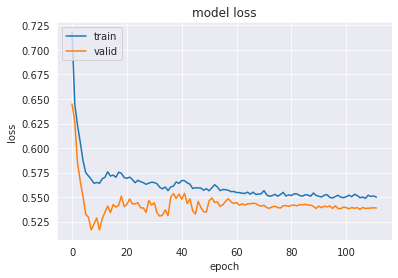

In [20]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [21]:
if False:
    index = 0
    lambda_net = lambda_net_dataset_train.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(),                                   
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )

    index = 0
    lambda_net = lambda_net_dataset_valid.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(), 
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )    

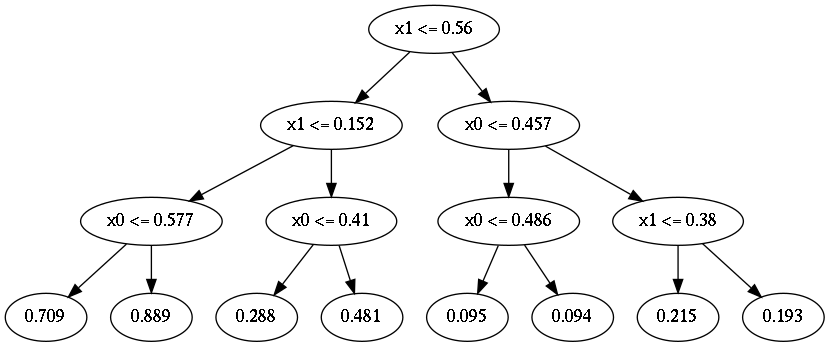

In [22]:
index = 0
if test_size > 0 and not evaluate_distribution:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    encoder_model = load_encoder_model(config)
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
image = None
if not function_value_loss:
    if test_size > 0 and not evaluate_distribution:
        dt_parameters = y_test[index][:-2 ** config['function_family']['maximum_depth'] ]
    else:
        dt_parameters = y_valid[index][:-2 ** config['function_family']['maximum_depth'] ]

    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 513)]        0           []                               
                                                                                                  
 hidden1_1792 (Dense)           (None, 1792)         921088      ['input[0][0]']                  
                                                                                                  
 activation1_sigmoid (Activatio  (None, 1792)        0           ['hidden1_1792[0][0]']           
 n)                                                                                               
                                                                                                  
 hidden2_512 (Dense)            (None, 512)          918016      ['activation1_sigmoid[0][0]']

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

## Train & Valid Data Evaluation

In [25]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of  50 | elapsed:   20.9s remaining:  8.4min
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:   29.5s finished


  0%|          | 0/50 [00:00<?, ?it/s]

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of  50 | elapsed:    0.8s remaining:   20.3s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:   10.4s finished


  0%|          | 0/50 [00:00<?, ?it/s]

## Test Data Evaluation (+ Distribution Evaluation)

In [26]:
#config['computation']['n_jobs'] = 60
#config['i_net']['test_size'] = 1000

In [27]:
if evaluate_distribution and test_size > 0:
    
    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list_distrib,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           distribution_list_evaluation = config['data']['distribution_list_eval'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=max_distributions_per_class,#max_distributions_per_class,
                                                                                           flip_percentage=noise_injected_level, #0.1,#
                                                                                           data_noise=data_noise, #0.1,#
                                                                                           random_parameters = random_parameters_distribution, #random_parameters_distribution
                                                                                           verbose=0,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:   33.7s
[Parallel(n_jobs=50)]: Done 188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=50)]: Done 412 tasks      | elapsed:  4.7min
[Parallel(n_jobs=50)]: Done 700 tasks      | elapsed:  7.7min
[Parallel(n_jobs=50)]: Done 1052 tasks      | elapsed: 11.6min
[Parallel(n_jobs=50)]: Done 1468 tasks      | elapsed: 16.4min
[Parallel(n_jobs=50)]: Done 1948 tasks      | elapsed: 21.6min
[Parallel(n_jobs=50)]: Done 2492 tasks      | elapsed: 27.4min
[Parallel(n_jobs=50)]: Done 3100 tasks      | elapsed: 34.3min
[Parallel(n_jobs=50)]: Done 3772 tasks      | elapsed: 41.8min
[Parallel(n_jobs=50)]: Done 4508 tasks      | elapsed: 49.9min
[Parallel(n_jobs=50)]: Done 5308 tasks      | elapsed: 59.1min
[Parallel(n_jobs=50)]: Done 6172 tasks      | elapsed: 68.7min
[Parallel(n_jobs=50)]: Done 7100 tasks      | elapsed: 79.0min
[Parallel(n_jobs=50)]: Done 8092 tasks      |

In [28]:
if evaluate_distribution and test_size > 0:
    #print(distribution_parameter_list_list[0])
    #print(lambda_net_dataset_valid.distribution_dict_list_list[0])

    inet_performance_distrib_evaluation = np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy'])
    print('I-Net Performance by Network: ', inet_performance_distrib_evaluation)

    mean_random_performance_distrib_evaluation = np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Mean Performance by Network: ', mean_random_performance_distrib_evaluation)

    max_random_performance_distrib_evaluation = np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Max Performance by Network: ', max_random_performance_distrib_evaluation)

    print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']))
    print('Median DT Distilled:', np.median(np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)))#np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))

    complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
    display(complete_distribution_evaluation_results.head(20))
    
    network_distances = get_print_network_distances_dataframe(distances_dict)
    display(network_distances.head(20))

I-Net Performance by Network:  [0.79  0.75  1.    ... 0.712 0.636 0.7  ]
Distilled Mean Performance by Network:  [0.928 0.774 1.    ... 0.994 0.974 0.962]
Distilled Max Performance by Network:  [0.928 0.774 1.    ... 0.994 0.974 0.962]
Median I-Net: 0.742
Median DT Distilled: 0.958


,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,ROC AUC Score Distilled Train Data,ROC AUC Score Distilled Data Random,ROC AUC Score Distilled,ROC AUC Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.977,0.989,0.914,0.737,0.603,0.495,0.612,0.660,0.086,0.032,0.513,0.529,0.976,0.989,0.908,0.691,0.987,0.991,0.936,0.755,0.007,0.007,0.007,0.367


,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,217.278,92.099,143.633,0.000,4.123,0.000
valid,231.446,101.146,149.109,49.145,4.417,1.532
test,227.484,98.540,148.969,45.510,4.307,1.594


In [29]:
#%load_ext autoreload
#%autoreload 2

Index:  36232
Feature 1:  Samples 3262 / 1738
	 Distribution 1: poisson
		 lam: 0.469
	 Distribution 2: poisson
		 lam: 4.784
Feature 2:  Samples 817 / 4183
	 Distribution 1: gamma
		 shape: 0.114
		 scale: 4.581
	 Distribution 2: gamma
		 shape: 0.562
		 scale: 0.385
Considered Columns:								 0   1
Performance Network:								 0.792
Fidelity DT Sklearn Train Data:							 0.99
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.35
Fidelity DT Sklearn Uniform Data:						 0.36
Fidelity DT Sklearn Normal Data:						 0.352
Fidelity DT I-Net:								 0.998


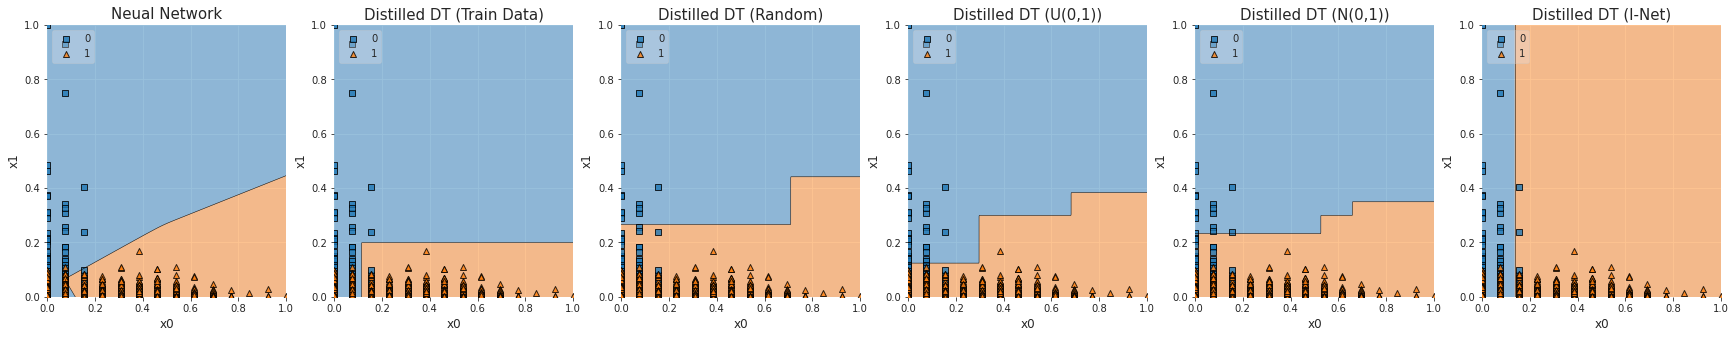

-----------------------------------------------------


In [38]:
if evaluate_distribution:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    identifier_folder = config['function_family']['dt_type'] + '_' + str(config['function_family']['decision_sparsity']) + '_' + timestr
    os.makedirs('./data/distrib_plots/' + identifier_folder + '/', exist_ok=True)
    


    index = 36232
    distrib_for_index = np.argmax(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']])[:,index])

    print('Index: ', index)
    distribution_dict = distribution_parameter_list_list[index]

    print('Feature 1: ', 'Samples', distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'])
    print('\t Distribution 1: ' + list(distribution_dict[0].keys())[0])
    for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_0'].items()):
        print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
    print('\t Distribution 2: ' + list(distribution_dict[0].keys())[0])
    for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_1'].items()):
        print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

    print('Feature 2: ', 'Samples', distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'])
    print('\t Distribution 1: ' + list(distribution_dict[1].keys())[0])
    for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_0'].items()):
        print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
    print('\t Distribution 2: ' + list(distribution_dict[1].keys())[0])
    for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_1'].items()):
        print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

    identifier_file = 'index' + str(index) + '_' + '_'.join([list(dist.keys())[0] + '_' +  '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_0'].items()]) + '_' + '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_1'].items()]) for dist in distribution_parameter_list_list[index]])

    plot_decision_area_evaluation_all_distrib(data_dict_list_test[index]['X_train'], 
                                        data_dict_list_test[index]['y_train'], 
                                        data_dict_list_test[index]['X_test'], 
                                        data_dict_list_test[index]['y_test'],
                                        None,
                                        None,
                                        network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config),
                                        dt_distilled_list_test[0][index][-3],
                                        dt_distilled_list_test[0][index][-2],
                                        dt_distilled_list_test[0][index][-1],
                                        [dt_distilled_list_test[i][index][0] for i in range(len(config['data']['distribution_list_eval']))],     
                                        dt_inet_list_test[0][index],
                                        np.array([str(i) for i in range(data_dict_list_test[index]['X_train'].shape[1])]),
                                        config['data']['distribution_list_eval'],
                                        config,
                                        identifier_folder = identifier_folder,
                                        identifier_file = identifier_file
                                       )    



I-Net Decision Tree


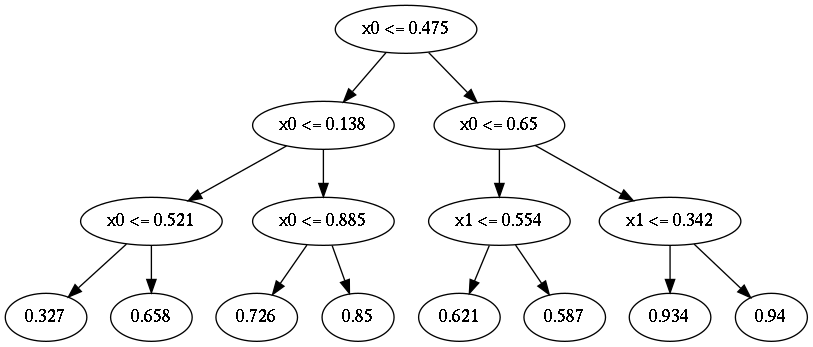

Random Data Decision Tree


<Figure size 1080x576 with 0 Axes>

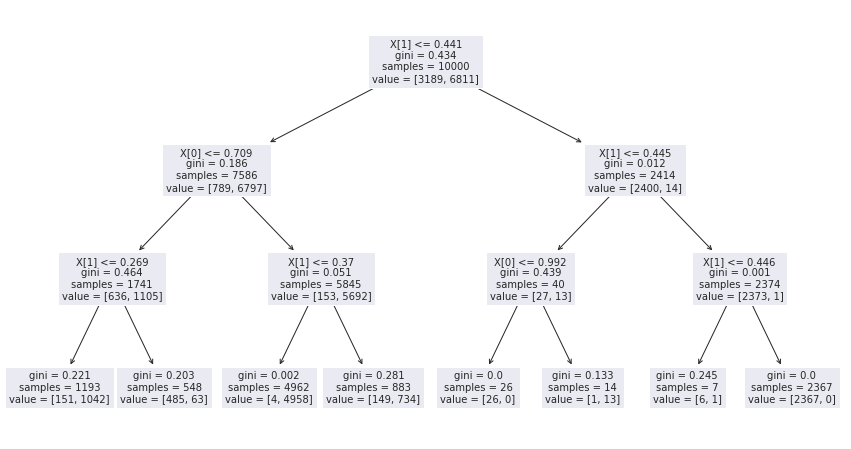

Train Data Decision Tree


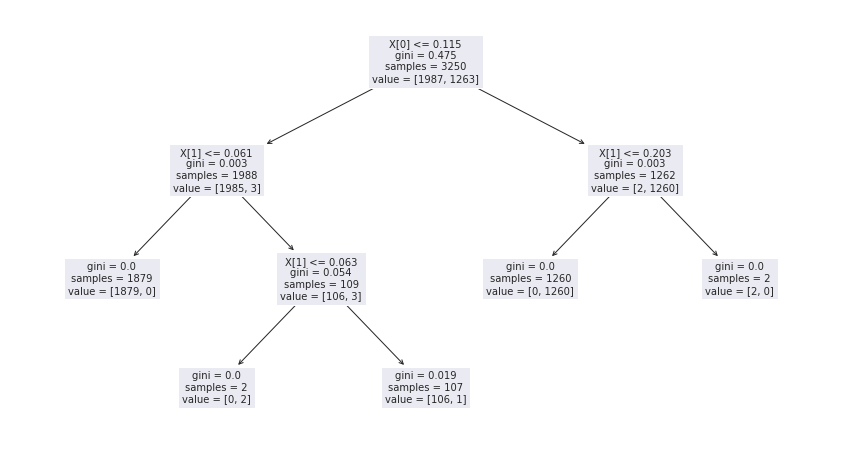

Uniform Data Decision Tree


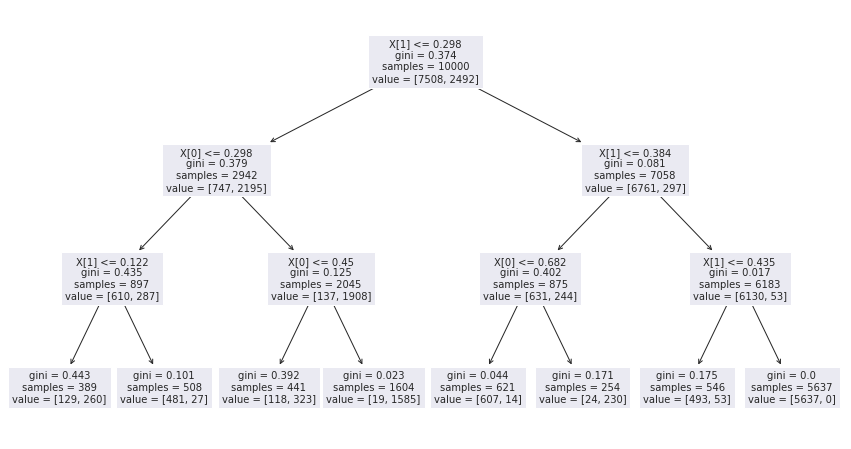

In [39]:
if config['function_family']['dt_type'] == 'vanilla':
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_inet = parameterDT(dt_inet_list_test[distrib_for_index][index], config)
    image = dt_inet.plot()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][0], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][1], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][2], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
else:
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_parameters = dt_inet_list_test[distrib_for_index][index]
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][0].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8)) 
    image = dt_distilled_list_test[distrib_for_index][index][1].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL'] 
    display(image)
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][2].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)

In [40]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(lambda_net_dataset_valid.network_parameters_array[index], config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test = lambda_net_dataset_valid.X_test_lambda_array[index],
                                  config = config)

In [41]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test =  data_dict_list_test[0]['X_test'],
                                  config = config)

In [35]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()